### Sources

[Introduction to Variational Inference](https://leimao.github.io/article/Introduction-to-Variational-Inference/) - Lei Mao, Sr. DL Engineer, NVIDIA, Santa Clara

[Variational Inference: A Review for Statisticians](https://arxiv.org/abs/1601.00670) - Blei et. al.

![Psuedo-code for coordinate ascent](../assets/VI_coord_ascent_gaussian_psuedo_code.png)

<p style="text-align: center;">Variational Inference for Gaussian Mixtures using Coordinate Ascent (Blei et. al.)</p>

In [4]:
#!pip install pomegranate

     |████████████████████████████████| 7.2 MB 736 kB/s eta 0:00:01


In [32]:
from pomegranate import *

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from typing import Optional, Union, Tuple

In [31]:
DF = pd.DataFrame
NP = np.ndarray

In [1]:


def EM_univariate_gaussian_optimizer():
    return

In [27]:
# Each entry in prior gaussians sets up a cluster center followed by the cluster standard deviation
prior_gaussians = [ 
    [-10,1],
    [0,1],
    [10,1]
]

dist_list = []

for k in prior_gaussians:
    dist_list.append(NormalDistribution(k[0],k[1]))

# Use GeneralMixtureModel in the pomegranate library to create a combined distribution
# from the individual Normal Distributions.
# The combined model is equivalent to a Gaussian Mixture model with as many Gaussaians as
# there are cluster centers
gaussian_mixture_model = GeneralMixtureModel(dist_list)

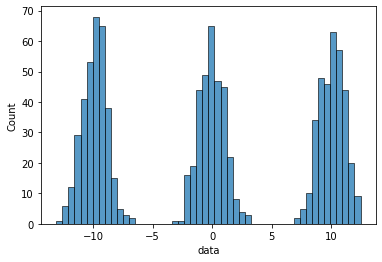

In [29]:
# Sample Data from the Gaussian Mixture model
data=pd.DataFrame(gaussian_mixture_model.sample(1000),columns=['data'])

# Visualize the distribution to make sure we are sampling data as expected
sns.histplot(data,x='data',bins=50)
plt.show()

In [17]:
class univariate_gaussian_variational_inference(object):
    def __init__(self,data:NP,K:int)->None:
        
        if not isinstance(data, NP) or len(data.shape)>1:
            raise Exception("Input Data MUST be a 1 dimensional numpy array")
            
        self.data=data
        self.K=K
        self.num_samples=data.shape[0]
        
    def init_variational_params(self)->Tuple[NP,NP,NP]:
        # Initialize Variational Parameters
        
        # For the m parameter, a reasonable initialization is 
        # finding the limits of the data and sampling from a 
        # uniform distribution within that range
        
        
        # For the S parameter, leave all standard deviations as one
        
        
        # For the C parameter, randomly assign all data point into 1 of K clusters
        
        
        
        
        

def coordinate_ascent_optimizer(
    data:NP,
    K:int # Number of clusters
):
    if not isinstance(data, NP) or len(data.shape)>1:
        raise Exception("Input Data MUST be a 1 dimensional numpy array")
    
    # initialize Variational Parameters
    
    
    
    return

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   data    1000 non-null   float64
dtypes: float64(1)
memory usage: 7.9 KB
